# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Описание проекта

Заказчик исследования — сеть отелей «Как в гостях».
Чтобы привлечь клиентов, сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменяет бронирование, то компания терпит убытки. Сотрудники отеля могут, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, нам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**Бизнес-метрика и другие данные**

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.
Стоимость номеров отеля:

    категория A: за ночь — 1 000, разовое обслуживание — 400;
    категория B: за ночь — 800, разовое обслуживание — 350;
    категория C: за ночь — 600, разовое обслуживание — 350;
    категория D: за ночь — 550, разовое обслуживание — 150;
    категория E: за ночь — 500, разовое обслуживание — 150;
    категория F: за ночь — 450, разовое обслуживание — 150;
    категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Описание данных

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:

    id — номер записи;
    adults — количество взрослых постояльцев;
    arrival_date_year — год заезда;
    arrival_date_month — месяц заезда;
    arrival_date_week_number — неделя заезда;
    arrival_date_day_of_month — день заезда;
    babies — количество младенцев;
    booking_changes — количество изменений параметров заказа;
    children — количество детей от 3 до 14 лет;
    country — гражданство постояльца;
    customer_type — тип заказчика:
        Contract — договор с юридическим лицом;
        Group — групповой заезд;
        Transient — не связано с договором или групповым заездом;
        Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
    days_in_waiting_list — сколько дней заказ ожидал подтверждения;
    distribution_channel — канал дистрибуции заказа;
    is_canceled — отмена заказа;
    is_repeated_guest — признак того, что гость бронирует номер второй раз;
    lead_time — количество дней между датой бронирования и датой прибытия;
    meal — опции заказа:
        SC — нет дополнительных опций;
        BB — включён завтрак;
        HB — включён завтрак и обед;
        FB — включён завтрак, обед и ужин.
    previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
    previous_cancellations — количество отменённых заказов у клиента;
    required_car_parking_spaces — необходимость места для автомобиля;
    reserved_room_type — тип забронированной комнаты;
    stays_in_weekend_nights — количество ночей в выходные дни;
    stays_in_week_nights — количество ночей в будние дни;
    total_nights — общее количество ночей;
    total_of_special_requests — количество специальных отметок.

### План проведения работы

Шаг 1. Откроем файлы с данными

Шаг 2. Предобработка и исследовательский анализ данных
   * Проверим данные и откорректируем их, если потребуется.
   * Проведём исследовательский анализ представленных данных. Опишем найденные особенности: пропуски, выбросы.
   
Шаг 3. Вычислим бизнес-метрику
   * Оценим прибыль отеля без внедрения депозитов.
   
Шаг 4. Разработка модели ML
   * Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. Опишем выводы.
   * Выберем метрику для обучения.
   * Оценим прибыль, которую принесёт выбранная модель за год.
   
Шаг 5. Выявим признаки «ненадёжного» клиента
   * На основе исследовательского анализа данных опишем клиента, склонного к отказу от брони.
   
Шаг 6. Напишем общий вывод
   * Опишем модель, которая решает задачу с наибольшей выгодой для бизнеса. Дадим бизнесу рекомендации по результатам проделанной работы.

## Загрузка и подготовка данных

Установим дополнительную библиотеку pandas_profiling для EDA.

In [1]:
!pip install pandas_profiling -q

Импортируем необходимые библиотеки.

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import pandas_profiling

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn import set_config
from sklearn.dummy import DummyClassifier

Объявим глобальные переменные.

In [3]:
# случайное зерно
SEED = 314159

Загрузим данные.

In [4]:
if os.path.exists('hotel_train.csv'):
    df_train = pd.read_csv('hotel_train.csv')
else:
    df_train = pd.read_csv('/datasets/hotel_train.csv')
    
if os.path.exists('hotel_test.csv'):
    df_test = pd.read_csv('hotel_test.csv')
else:
    df_test = pd.read_csv('/datasets/hotel_test.csv')

Сделаем первичный осмотр.

In [5]:
df_train.info()
print()
df_test.info()
print()
display(df_train.head())
display(df_test.head())
display(df_train.describe().transpose())
display(df_test.describe().transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


,count,mean,std,min,25%,50%,75%,max
id,65229.0,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0


,count,mean,std,min,25%,50%,75%,max
id,32412.0,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,0.388467,0.487409,0.0,0.00,0.0,1.00,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.00,76.0,155.00,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.00,2017.0,2017.00,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.00,18.0,25.00,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.00,15.5,23.00,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.00,1.0,2.00,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.00,2.0,3.00,6.0
adults,32412.0,1.858602,0.489341,0.0,2.00,2.0,2.00,4.0
children,32412.0,0.083765,0.343470,0.0,0.00,0.0,0.00,3.0


## Предобработка и исследовательский анализ данных

Проверим данные и откорректируем их, если потребуется.

Проведём исследовательский анализ представленных данных. Опишем найденные особенности: пропуски, выбросы.

Также для EDA воспользуемся библиотекой pandas_profiling.

In [6]:
df_train.profile_report().to_file("df_train_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_test.profile_report().to_file("df_test_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Пропусков в данных нет и дубликатов нет.

Столбец `id` не значимый, можно удалить.

In [8]:
df_train.drop(columns='id', inplace=True)
df_test.drop(columns='id', inplace=True)

В столбцах `reserved_room_type` и `meal` есть лишние пробелы, необходимо убрать.

In [9]:
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()
df_train['meal'] = df_train['meal'].str.strip()
df_test['meal'] = df_test['meal'].str.strip()

Проверим на наличие дубликатов.

In [10]:
print(df_train.duplicated().value_counts())
print(df_test.duplicated().value_counts())

False    43852
True     21377
dtype: int64
False    24695
True      7717
dtype: int64


После удаления столбца `id` обнаружилось значительно количество полных дубликатов. Выяснить их природу без связи с человеком выгружавшим данные не представляется возможным. Поскольку даже без этих строк количество данных остаётся значительным - примем решение отбросить их.

In [11]:
df_train.drop_duplicates(inplace=True, ignore_index=True)
df_test.drop_duplicates(inplace=True, ignore_index=True)

Изучим аномальные значения используя pandas_profiling отчёт.

В столбце `babies` есть по одному значению больше 2х, отбросим выбивающиеся значения.

In [12]:
df_train.drop(df_train[df_train['babies'] > 2].index, inplace=True)
df_test.drop(df_test[df_test['babies'] > 2].index, inplace=True)

В столбце `previous_cancellations` всего 15 уникальных значений, при этом только от 0 до 5 идут непрерывно и имеют существенную частоту. Удалим всё что выше 5.

In [13]:
df_train.drop(df_train[df_train['previous_cancellations'] > 5].index, inplace=True)
df_test.drop(df_test[df_test['previous_cancellations'] > 5].index, inplace=True)

В столбце `previous_bookings_not_canceled` значения распределены от 0 до 50, но значений выше 20 лишь 55 и они не непрерывны. Отбросим строчки со значением выше 20.

In [14]:
df_train.drop(df_train[df_train['previous_bookings_not_canceled'] > 20].index, inplace=True)
df_test.drop(df_test[df_test['previous_bookings_not_canceled'] > 20].index, inplace=True)

В столбце `booking_changes` отбросим значения выше 10.

In [15]:
df_train.drop(df_train[df_train['booking_changes'] > 10].index, inplace=True)
df_test.drop(df_test[df_test['booking_changes'] > 10].index, inplace=True)

В столбце `required_car_parking_spaces` отбросим значения выше 1.

In [16]:
df_train.drop(df_train[df_train['required_car_parking_spaces'] > 1].index, inplace=True)
df_test.drop(df_test[df_test['required_car_parking_spaces'] > 1].index, inplace=True)

Проверим невозможные бронирования.

Только дети, без взрослых.

In [17]:
df_train.query('(children > 0 | babies > 0) & adults == 0').shape[0]

149

Отбросим эти значения.

In [18]:
df_train.drop(df_train.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)
df_test.drop(df_test.query('(children > 0 | babies > 0) & adults == 0').index, inplace=True)

Заселения без постояльцев.

In [19]:
df_train.query('adults == 0').shape[0]

15

Избавимся от этих значений.

In [20]:
df_train.drop(df_train.query('adults == 0').index, inplace=True)
df_test.drop(df_test.query('adults == 0').index, inplace=True)

Обновим индексы.

In [21]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

Проверим данные на мультиколлинеарность, изучив фактор инфляции дисперсии (VIF). VIF больше 5 говорит о высокой степени коллинеарности.

In [22]:
numeric = list(df_train.select_dtypes('number').columns)
numeric.remove('arrival_date_year')

pd.Series(
    [variance_inflation_factor(df_train[numeric].values, i) for i in range(df_train[numeric].shape[1])],
    index=df_train[numeric].columns
)

C:\Users\Admin\.conda\envs\practicum\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


is_canceled                       1.525533
lead_time                         2.296636
arrival_date_week_number          5.196680
arrival_date_day_of_month         3.862725
stays_in_weekend_nights                inf
stays_in_week_nights                   inf
adults                            8.333553
children                          1.085172
babies                            1.032995
is_repeated_guest                 1.617198
previous_cancellations            1.176152
previous_bookings_not_canceled    1.626892
booking_changes                   1.176224
days_in_waiting_list              1.045032
required_car_parking_spaces       1.131049
total_of_special_requests         1.859096
total_nights                           inf
dtype: float64

Столбцы `stays_in_week_nights`, `stays_in_weekend_nights` и `total_nights` являются мультиколлинеарными. Для корректной работы линейных моделей следует избавиться от одного. А вот столбец `adults` придётся оставить, т.к. у нас нет явной зависимости от других столбцов.

In [23]:
df_train.drop(columns='stays_in_weekend_nights', inplace=True)
df_test.drop(columns='stays_in_weekend_nights', inplace=True)

Проверим ещё раз коллинеарность.

In [24]:
numeric = list(df_train.select_dtypes('number').columns)
numeric.remove('arrival_date_year')

pd.Series(
    [variance_inflation_factor(df_train[numeric].values, i) for i in range(df_train[numeric].shape[1])],
    index=df_train[numeric].columns
)

is_canceled                        1.525533
lead_time                          2.296636
arrival_date_week_number           5.196680
arrival_date_day_of_month          3.862725
stays_in_week_nights              17.773192
adults                             8.333553
children                           1.085172
babies                             1.032995
is_repeated_guest                  1.617198
previous_cancellations             1.176152
previous_bookings_not_canceled     1.626892
booking_changes                    1.176224
days_in_waiting_list               1.045032
required_car_parking_spaces        1.131049
total_of_special_requests          1.859096
total_nights                      20.175197
dtype: float64

Высокий фактор остался у столбца `total_nights` (не можем удалить) и `stays_in_week_nights`. Если линейные модели не будут нормально конвергировать, придётся удалить и его.

Заменим типы данных на более рациональные.

In [25]:
# uint8 колонки
uint8_columns = [
    'is_canceled', 'arrival_date_day_of_month',
    'stays_in_week_nights', 'adults', 'children',
    'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'
]

# uint16 колонки
uint16_columns = ['lead_time', 'days_in_waiting_list']

# category колонки
category_columns = [
    'arrival_date_year', 'arrival_date_month', 'meal', 'country',
    'distribution_channel', 'reserved_room_type', 'customer_type'
]

# изменяем dtypes колонок
df_train = df_train.astype({
    **{_:'uint8' for _ in uint8_columns},
    **{_:'uint16' for _ in uint16_columns},
    **{_:'category' for _ in category_columns}
})

df_test = df_test.astype({
    **{_:'uint8' for _ in uint8_columns},
    **{_:'uint16' for _ in uint16_columns},
    **{_:'category' for _ in category_columns}
})

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43570 entries, 0 to 43569
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   is_canceled                     43570 non-null  uint8   
 1   lead_time                       43570 non-null  uint16  
 2   arrival_date_year               43570 non-null  category
 3   arrival_date_month              43570 non-null  category
 4   arrival_date_week_number        43570 non-null  int64   
 5   arrival_date_day_of_month       43570 non-null  uint8   
 6   stays_in_week_nights            43570 non-null  uint8   
 7   adults                          43570 non-null  uint8   
 8   children                        43570 non-null  uint8   
 9   babies                          43570 non-null  uint8   
 10  meal                            43570 non-null  category
 11  country                         43570 non-null  category
 12  distribution_chann

### Вывод

Мы загрузили данные и просмотрели основные сведения. Данные хорошо подготовлены, нет пропусков, но много дубликатов. К сожалению, от этой части данных пришлось избавиться.

Удалили неинформативный столбец `id`, удалили лишние пробелы.

Провели анализ выбивающихся значений и удалили их.

Провели анализ на мультиколлинеарность и удалили лишние столбцы.

Матрицы корреляции Пирсона показывают высокую зависимость вероятности отмены от срока между бронированием и заездом, предыдущих отмен, а также обратную зависимость от специальных заказов и бронирования парковочных мест.

Провели замену типов данных на более рациональные, что позволило уменьшить размер датафреймов на 86%.

## Вычислим бизнес-метрику

Оценим прибыль отеля без внедрения депозитов.

Создадим словари со значениями стоимости ночи и стоимости уборки номера по категориям, а также с коэффициентами сезонности.

In [27]:
price = {
    'A':[1000, 400],
    'B':[800, 350],
    'C':[600, 350],
    'D':[550, 150],
    'E':[500, 150],
    'F':[450, 150],
    'G':[350, 150]
}

season = {
    'January':1,
    'February':1,
    'March':1.2,
    'April':1.2,
    'May':1.2,
    'June':1.4,
    'July':1.4,
    'August':1.4,
    'September':1.2,
    'October':1.2,
    'November':1.2,
    'December':1    
}

Напишем функцию которая вычисляет прибыль.

Вспомним что многие клиенты получившие предложение внести залог могут отказаться от услуг нешего отеля. Какая часть клиентов уйдёт точно посчитать без проведения А/В тестов невозможно.

Ко всем моделям добавим дополнительную метрику - доход исходя из предположения, что 50% клиентов получивших предложение о внесении залога откажутся от бронирования номера и отель не получит ничего.

In [28]:
def income(row, refuse=False):
    
    '''
    Функция вычисляет доход по каждой строке, в зависимости от типа комнаты, длительности проживания.
    С учётом сезонности и обслуживания номеров.
    Если появляется столбец с предсказаниями - учитывает возможность удержания залога при отмене брони.
    Если параметр refuse == True - вводит поправку на доход от очередного клиента - 50%.
    '''
    # введём поправку на отказником
    if refuse:
        ref_mod = 0.5
    else:
        ref_mod = 1
    
    # вычислим количество уборок
    if row['total_nights'] % 2 != 0:
        cleanings = 1 + row['total_nights'] // 2
    else:
        cleanings = row['total_nights'] // 2
        
    # вычислим доход
    if 'is_canceled_p' not in list(row.index):
        if row['is_canceled'] == 1:
            return - (price[row['reserved_room_type']][0] * season[row['arrival_date_month']]
                      + price[row['reserved_room_type']][1] * cleanings)
        else:
            return (price[row['reserved_room_type']][0] * row['total_nights'] * season[row['arrival_date_month']]
                    - price[row['reserved_room_type']][1] * cleanings)
    else:
        if row['is_canceled'] == 1 and row['is_canceled_p'] == 0:
            return - (price[row['reserved_room_type']][0] * season[row['arrival_date_month']]
                      + price[row['reserved_room_type']][1] * cleanings)
        elif row['is_canceled'] == 1 and row['is_canceled_p'] == 1:
            return (price[row['reserved_room_type']][0] * season[row['arrival_date_month']] * .8
                    - price[row['reserved_room_type']][1]) * ref_mod
        elif row['is_canceled'] == 0 and row['is_canceled_p'] == 1:
            return (price[row['reserved_room_type']][0] * row['total_nights'] * season[row['arrival_date_month']]
                    - price[row['reserved_room_type']][1] * cleanings) * ref_mod            
        else:
            return (price[row['reserved_room_type']][0] * row['total_nights'] * season[row['arrival_date_month']]
                    - price[row['reserved_room_type']][1] * cleanings)

Применим функцию для добавления столбца с доходами.

In [29]:
df_train['income'] = df_train.apply(income, refuse=True, axis=1).astype('int32')
df_test['income'] = df_test.apply(income, refuse=True, axis=1).astype('int32')

Проверим некоторые случайные строки.

In [30]:
df_train.sample(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,income
17544,1,74,2016,March,13,24,3,2,0,0,...,0,0,D,0,0,Transient,0,0,3,-960
39039,0,72,2016,September,39,19,3,2,0,0,...,0,0,D,0,0,Transient,0,1,4,2340
9210,0,113,2016,April,18,26,2,1,0,0,...,0,0,G,1,0,Transient,0,1,2,690
14774,0,16,2015,September,37,9,4,2,0,0,...,0,0,A,0,0,Contract,0,3,4,4000
34613,0,18,2016,June,27,30,3,2,1,0,...,0,0,A,0,0,Transient,0,1,3,3400


Посмотрим на выручку по годам.

In [31]:
pd.concat([df_train, df_test]).pivot_table(values='income', index='arrival_date_year', aggfunc=['count', 'sum', 'mean'])

,count,sum,mean
,income,income,income
arrival_date_year,,,
2015,9820,18330956,1866.696130
2016,33750,48575438,1439.272237
2017,24569,32219684,1311.395824


In [32]:
print(df_train['income'].sum() / 1e6)
print(df_test['income'].sum()/ 1e6)

66.906394
32.219684


### Вывод

Мы подсчитали прибыль отеля по каждой записи, теперь можно переходить к разработке модели ML.

## Разработка модели ML

Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.

Поскольку данные не сильно дисбалансированы, будем использовать метрики F1, Accuracy, матрицу ошибок, Precision, Recall и прибыль.

Чтобы не дать моделям максимизировать прибыль ценой задирания метрики FP, которая модет привести к вторичному падению доходов за счёт передумавших клиентов, для выбора лучших гиперпараметров будем использовать гармоническое среднее F1.

Оценим прибыль, которую принесёт выбранная модель за последний год.

Для обучения будем использовать три модели на ансаблях:

   * **RandomForestClassifier**
   * **AdaBoostClassifier**
   * **GradientBoostingClassifier**
   
Линейную модель:

   * **LogisticRegression**
  
Модель на методе опорных векторов:

   * **LinearSVC**

Изменим настройки отображения для удобства просмотра.

In [33]:
set_config(display='diagram')

Напишем функцию оценки прибыли для применения в подборе параметров кросс-валидацией при поиске по сетке.

In [34]:
def income_scorer(est, X, y, df=df_train, refuse=False):
    '''
    Функция оценки разницы прибыли для поиска гиперпараметров по сетке.
    '''
    # получим предсказанные значения столбца is_canceled_p
    y_pred = pd.Series(est.predict(X), index=X.index, name='is_canceled_p')

    # добавим предсказанные значения к признакам
    df = df.iloc[X.index].join(y_pred)
    
    # вычислим прибыль
    df['income'] = df.apply(income, refuse=refuse, axis=1)
    
    return df['income'].sum() / 1e6

Разделим обучающие и тестовые данные на features(X) и target(y).

In [35]:
X = df_train.drop(['is_canceled', 'income'], axis=1)
y = df_train['is_canceled']
X_test = df_test.drop(['is_canceled', 'income'], axis=1)
y_test = df_test['is_canceled']

Найдём результаты для случайной и константной моделей.

In [36]:
model_dc = DummyClassifier(strategy='uniform', random_state=SEED)
model_dc.fit(X, y)
prediction_dc = model_dc.predict(X_test)

f1 = f1_score(y_test, prediction_dc).round(decimals=3)
print(f'Метрика F1 на случайной модели составила {f1}')
accuracy = accuracy_score(y_test, prediction_dc).round(decimals=3)
print(f'Метрика Accuracy на случайной модели составила {accuracy}')
precision = precision_score(y_test, prediction_dc).round(decimals=3)
print(f'Метрика Precision на случайной модели составила {precision}')
recall = recall_score(y_test, prediction_dc).round(decimals=3)
print(f'Метрика Recall на случайной модели составила {recall}')
score = income_scorer(model_dc, X_test, y_test, df_test).round(decimals=3)
print(f'Прибыль за 2017 год составила {score} млн. рублей')
score_mod = income_scorer(model_dc, X_test, y_test, df_test, refuse=True).round(decimals=3)
print(f'Прибыль с учётом модификатора отказа за 2017 год составила {score_mod} млн. рублей')

Метрика F1 на случайной модели составила 0.386
Метрика Accuracy на случайной модели составила 0.499
Метрика Precision на случайной модели составила 0.315
Метрика Recall на случайной модели составила 0.499
Прибыль за 2017 год составила 40.725 млн. рублей
Прибыль с учётом модификатора отказа за 2017 год составила 28.416 млн. рублей


In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, prediction_dc).ravel()
(tn, fp, fn, tp)

(8402, 8411, 3887, 3869)

Занесём результаты в сводную таблицу.

In [38]:
results_table = {}

results_table['DummyClassifierRandom'] = [f1, accuracy, tn, fp, fn, tp, precision, recall, score, score_mod]

Видно, что даже случайная модель даёт в сценарии с введением депозитов прирост выручки на 8.5 млн рублей за счёт случайно совпавших предсказаний с реальной отменой **TP**. Но случайная модель даёт много ложно положительных **FP** что в итоге приводит к падению общего дохода с учётом модификатора отказа.

Проверим так же константную модель.

In [39]:
model_dc_mf = DummyClassifier(strategy='most_frequent', random_state=SEED)
model_dc_mf.fit(X, y)
prediction_dc_mf = model_dc_mf.predict(X_test)

f1 = f1_score(y_test, prediction_dc_mf)
print(f'Метрика F1 на константной модели составила {f1}')
accuracy = accuracy_score(y_test, prediction_dc_mf).round(decimals=3)
print(f'Метрика Accuracy на константной модели составила {accuracy}')
precision = precision_score(y_test, prediction_dc_mf).round(decimals=3)
print(f'Метрика Precision на случайной модели составила {precision}')
recall = recall_score(y_test, prediction_dc_mf).round(decimals=3)
print(f'Метрика Recall на случайной модели составила {recall}')
score = income_scorer(model_dc_mf, X_test, y_test, df_test).round(decimals=3)
print(f'Прибыль за 2017 год составила {score} млн. рублей')
score_mod = income_scorer(model_dc_mf, X_test, y_test, df_test, refuse=True).round(decimals=3)
print(f'Прибыль с учётом модификатора отказа за 2017 год составила {score_mod} млн. рублей')

Метрика F1 на константной модели составила 0.0
Метрика Accuracy на константной модели составила 0.684
Метрика Precision на случайной модели составила 0.0
Метрика Recall на случайной модели составила 0.0


C:\Users\Admin\.conda\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Прибыль за 2017 год составила 32.22 млн. рублей
Прибыль с учётом модификатора отказа за 2017 год составила 32.22 млн. рублей


In [40]:
tn, fp, fn, tp = confusion_matrix(y_test, prediction_dc_mf).ravel()
results_table['DummyClassifierConstant'] = [f1, accuracy, tn, fp, fn, tp, precision, recall, score, score_mod]
(tn, fp, fn, tp)

(16813, 0, 7756, 0)

Создадим функцию для оценки метрик моделей.

In [41]:
def model_score(estimator):
    
    '''
    Функция вывода отчёта по результатам подбора гиперпараметров выбранной модели.
    '''
    
    # основные метрики
    f1 = f1_score(y_test, estimator.predict(X_test)).round(decimals=3)
    print(f'Метрика F1 составила {f1}')
    accuracy = accuracy_score(y_test, estimator.predict(X_test)).round(decimals=3)
    print(f'Метрика Accuracy составила {accuracy}')
    precision = precision_score(y_test, estimator.predict(X_test)).round(decimals=3)
    print(f'Метрика Precision составила {precision}')
    recall = recall_score(y_test, estimator.predict(X_test)).round(decimals=3)
    print(f'Метрика Recall составила {recall}')
    income_score = income_scorer(estimator, X_test, y_test, df_test).round(decimals=3)
    print(f'Доход за 2017 год составил {income_score} млн. рублей')
    income_score_mod = income_scorer(estimator, X_test, y_test, df_test, refuse=True).round(decimals=3)
    print(f'Доход с учётом модификатора отказа за 2017 год составил {income_score_mod} млн. рублей')
    
    # матрица ошибок
    display(pd.DataFrame(
        [confusion_matrix(y_test, estimator.predict(X_test)).ravel().tolist(),
         confusion_matrix(y_test, prediction_dc).ravel().tolist()],
        columns=['TN', 'FP', 'FN', 'TP'],
        index=['Для оцениваемой модели', 'Для случайной модели']
    ))
    tn, fp, fn, tp = confusion_matrix(y_test, estimator.predict(X_test)).ravel()
    
    # занесём результаты в сводную таблицу
    results_table[estimator.best_estimator_.named_steps[estimator.best_estimator_.steps[1][0]].__class__.__name__]\
         = [f1, accuracy, tn, fp, fn, tp, precision, recall, income_score, income_score_mod]
    return None

### Модель RandomForestClassifier()

Создадим трансформер для различных колонок, в случае с "деревянными моделями" к категориальным применим OE, числовые оставим как есть.

In [42]:
ensemble_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            dtype='int16',
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include='category')
    ),
    remainder='passthrough'
)

Создадим pipeline для классификатора RandomForestClassifier().

In [43]:
pipe_rf = make_pipeline(
    ensemble_transformer,
    RandomForestClassifier(
        random_state=SEED,
        n_jobs=-1,
        class_weight='balanced',
        verbose=0
    )
)

Зададим сетку параметров и создадим estimator.

In [44]:
param_grid = {
    'randomforestclassifier__n_estimators':np.arange(100, 151, 50),
    'randomforestclassifier__max_depth':np.arange(1, 10, 1),
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring={'income_scorer':income_scorer, 'f1':'f1', 'accuracy':'accuracy', 'precision':'precision', 'recall':'recall'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [45]:
%time gs_rf.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: total: 6.83 s
Wall time: 1min 1s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000020C45E6AA60>)])),
                                       ('randomforestclassifier',
                                        RandomForestClassif...alanced',
                                                               n_jobs=-1,
                                                               random_state=314159))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'randomforestclassifier__n_estimators': array([100, 150])},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'income_scorer': <function income_scorer at 0x0000020C45B15430>,
                      'precision': 'precision', 'recall': 'recall'},
             verbose=1)

Посмотрим на результаты обучения.

In [46]:
pd.DataFrame(gs_rf.cv_results_)[[
    'param_randomforestclassifier__max_depth', 'param_randomforestclassifier__n_estimators',
    'mean_test_f1', 'rank_test_f1',
    'mean_test_accuracy', 'rank_test_accuracy',
    'mean_test_precision', 'rank_test_precision',
    'mean_test_recall', 'rank_test_recall',
    'mean_test_income_scorer', 'rank_test_income_scorer'
]]

,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,mean_test_f1,rank_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall,mean_test_income_scorer,rank_test_income_scorer
0,1,100,0.420832,5,0.552146,16,0.325200,14,0.614825,3,16.430709,4
1,1,150,0.419165,8,0.535185,18,0.317618,18,0.634319,1,16.523417,1
2,2,100,0.420415,6,0.553707,15,0.325296,13,0.614099,4,16.431060,3
3,2,150,0.419736,7,0.544159,17,0.321258,17,0.624569,2,16.481742,2
4,3,100,0.421676,3,0.563438,14,0.333486,11,0.598578,5,16.369589,5
5,3,150,0.421184,4,0.568694,12,0.333188,12,0.590553,6,16.328279,6
6,4,100,0.424673,2,0.581111,10,0.343147,5,0.579719,8,16.281767,8
7,4,150,0.428059,1,0.584462,7,0.344672,4,0.583513,7,16.295081,7
8,5,100,0.406527,12,0.585839,4,0.340158,6,0.532070,12,16.034098,12
9,5,150,0.411980,11,0.584875,5,0.339419,7,0.548224,10,16.115485,10


Результаты не поражают воображение, но посмотрим на прирост дохода от введения модели с такой точностью. Общая прибыль на тесте до введения модели депозитов составляла 32,22 млн рублей.

In [47]:
model_score(gs_rf)

Метрика F1 составила 0.551
Метрика Accuracy составила 0.71
Метрика Precision составила 0.539
Метрика Recall составила 0.563
Доход за 2017 год составил 41.812 млн. рублей
Доход с учётом модификатора отказа за 2017 год составил 34.697 млн. рублей


,TN,FP,FN,TP
Для оцениваемой модели,13080,3733,3389,4367
Для случайной модели,8402,8411,3887,3869


На тесте мы получили разницу по прибыли в 9,5 млн рублей за неполный год. Если же учесть негативный эффект от введения залогов, то прибыль вырастет только на 2,5 млн рублей.

### Модель AdaBoostClassifier()

Попробуем улучшить результат на других моделях. Исследуем AdaBoostClassifier.

Создадим pipeline для классификатора AdaBoostClassifier().

In [48]:
pipe_ab = make_pipeline(
    ensemble_transformer,
    AdaBoostClassifier(
        random_state=SEED
    )
)

Зададим сетку параметров и создадим estimator.

In [49]:
param_grid = {
    'adaboostclassifier__learning_rate':np.arange(1, 1.5, 0.1),
    'adaboostclassifier__n_estimators':[50, 100, 150]
}

gs_ab = GridSearchCV(
    pipe_ab,
    param_grid,
    scoring={'income_scorer':income_scorer, 'f1':'f1', 'accuracy':'accuracy', 'precision':'precision', 'recall':'recall'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [50]:
%time gs_ab.fit(X, y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 5.11 s
Wall time: 1min 28s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000020C45E6AA60>)])),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier(random_state=314159))]),
             n_jobs=-1,
             param_grid={'adaboostclassifier__learning_rate': array([1. , 1.1, 1.2, 1.3, 1.4]),
                         'adaboostclassifier__n_estimators': [50, 100, 150]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'income_scorer': <function income_scorer at 0x0000020C45B15430>,
                      'precision': 'precision', 'recall': 'recall'},
             verbose=1)

Проверим результаты.

In [51]:
pd.DataFrame(gs_ab.cv_results_)[[
    'param_adaboostclassifier__learning_rate', 'param_adaboostclassifier__n_estimators',
    'mean_test_f1', 'rank_test_f1',
    'mean_test_accuracy', 'rank_test_accuracy',
    'mean_test_precision', 'rank_test_precision',
    'mean_test_recall', 'rank_test_recall',
    'mean_test_income_scorer', 'rank_test_income_scorer'
]]

,param_adaboostclassifier__learning_rate,param_adaboostclassifier__n_estimators,mean_test_f1,rank_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall,mean_test_income_scorer,rank_test_income_scorer
0,1.0,50,0.267551,10,0.684485,1,0.359708,2,0.234972,14,14.527563,13
1,1.0,100,0.266042,11,0.679160,4,0.352842,5,0.236956,12,14.538603,12
2,1.0,150,0.267869,9,0.677117,12,0.351928,8,0.241558,7,14.563459,7
3,1.1,50,0.271249,4,0.682190,2,0.359758,1,0.240297,8,14.552050,9
4,1.1,100,0.270203,5,0.679137,5,0.352259,6,0.241920,6,14.567520,4
5,1.1,150,0.268473,7,0.678494,6,0.351964,7,0.240206,9,14.558009,8
6,1.2,50,0.262827,14,0.676819,14,0.348229,13,0.236686,13,14.524016,14
7,1.2,100,0.265318,13,0.677875,7,0.351046,10,0.237769,11,14.547284,11
8,1.2,150,0.267910,8,0.677209,10,0.347996,14,0.242551,5,14.567354,5
9,1.3,50,0.272533,3,0.677140,11,0.354034,4,0.243906,3,14.564626,6


Проверим метрики.

In [52]:
model_score(gs_ab)

Метрика F1 составила 0.177
Метрика Accuracy составила 0.707
Метрика Precision составила 0.788
Метрика Recall составила 0.099
Доход за 2017 год составил 34.067 млн. рублей
Доход с учётом модификатора отказа за 2017 год составил 33.534 млн. рублей


,TN,FP,FN,TP
Для оцениваемой модели,16605,208,6985,771
Для случайной модели,8402,8411,3887,3869


Модель лучше отличает негативные классы и хуже позитивные, поэтому проиграла даже случайной, но у неё сильно меньшее число **FP**, что может положительно сказаться на отношении клиентов.

### Модель GradientBoostingClassifier()

Проверим модель GradientBoostingClassifier().

In [53]:
pipe_gb = make_pipeline(
    ensemble_transformer,
    GradientBoostingClassifier(
        random_state=SEED
    )
)

Зададим сетку параметров и создадим estimator.

In [54]:
param_grid = {
    'gradientboostingclassifier__loss':['deviance', 'exponential'],
    'gradientboostingclassifier__learning_rate':[.005, .01, .05],
    'gradientboostingclassifier__n_estimators':[100, 200, 300]
}

gs_gb = GridSearchCV(
    pipe_gb,
    param_grid,
    scoring={'income_scorer':income_scorer, 'f1':'f1', 'accuracy':'accuracy', 'precision':'precision', 'recall':'recall'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [55]:
%time gs_gb.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: total: 16.9 s
Wall time: 6min 5s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000020C45E6AA60>)])),
                                       ('gradientboostingclassifier',
                                        GradientBoostin...
             param_grid={'gradientboostingclassifier__learning_rate': [0.005,
                                                                       0.01,
                                                                       0.05],
                         'gradientboostingclassifier__loss': ['deviance',
                                                              'exponential'],
                         'gradientboostingclassifier__n_estimators': [100, 200,
                                                                      300]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'income_scorer': <function income_scorer at 0x0000020C45B15430>,
                      'precision': 'precision', 'recall': 'recall'},
             verbose=1)

Проверим результаты.

In [56]:
pd.DataFrame(gs_gb.cv_results_)[[
    'param_gradientboostingclassifier__learning_rate', 'param_gradientboostingclassifier__loss',
    'param_gradientboostingclassifier__n_estimators',
    'mean_test_f1', 'rank_test_f1',
    'mean_test_accuracy', 'rank_test_accuracy',
    'mean_test_precision', 'rank_test_precision',
    'mean_test_recall', 'rank_test_recall',
    'mean_test_income_scorer', 'rank_test_income_scorer'
]]

,param_gradientboostingclassifier__learning_rate,param_gradientboostingclassifier__loss,param_gradientboostingclassifier__n_estimators,mean_test_f1,rank_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_precision,rank_test_precision,mean_test_recall,rank_test_recall,mean_test_income_scorer,rank_test_income_scorer
0,0.005,deviance,100,0.001439,17,0.745651,7,0.200000,12,0.000722,17,13.383562,17
1,0.005,deviance,200,0.027719,13,0.748933,2,0.200000,12,0.014892,13,13.460536,13
2,0.005,deviance,300,0.034148,11,0.743562,8,0.291410,10,0.018320,11,13.477632,11
3,0.005,exponential,100,0.000000,18,0.745674,6,0.000000,18,0.000000,18,13.381342,18
4,0.005,exponential,200,0.015778,16,0.747441,5,0.200000,12,0.008213,16,13.425826,16
5,0.005,exponential,300,0.028966,12,0.749002,1,0.200000,12,0.015614,12,13.463662,12
6,0.01,deviance,100,0.027563,14,0.748910,3,0.200000,12,0.014801,14,13.460254,14
7,0.01,deviance,200,0.073720,9,0.737709,10,0.307850,8,0.041957,9,13.595239,9
8,0.01,deviance,300,0.132902,7,0.721024,12,0.360900,3,0.097986,7,13.876282,7
9,0.01,exponential,100,0.017106,15,0.747670,4,0.200000,12,0.008935,15,13.430015,15


Посмотрим на прирост дохода от введения модели с такой точностью.

In [57]:
model_score(gs_gb)

Метрика F1 составила 0.218
Метрика Accuracy составила 0.714
Метрика Precision составила 0.793
Метрика Recall составила 0.126
Доход за 2017 год составил 34.525 млн. рублей
Доход с учётом модификатора отказа за 2017 год составил 33.839 млн. рублей


,TN,FP,FN,TP
Для оцениваемой модели,16557,256,6776,980
Для случайной модели,8402,8411,3887,3869


Результат сходный с моделью AdaBoostClassifier. Проверим линейные модели.

### Модель LogisticRegression()

Создадим трансформер для различных колонок, в случае с "линейными" моделями к категориальным применим OHE, к числовым - StandardScaler.

In [58]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            handle_unknown='ignore'
        ), make_column_selector(dtype_include='category')
    ),
    (
        StandardScaler(
        ), make_column_selector(dtype_include='number')
    ),
    remainder='passthrough'
)

Соберём pipeline для логистической регрессии.

In [59]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    )
)

Зададим сетку параметров и создадим estimator.

In [60]:
param_grid = {
    'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__C':[.001, .01],
    'logisticregression__max_iter':[500, 1000]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring={'income_scorer':income_scorer, 'f1':'f1', 'accuracy':'accuracy'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [61]:
%time gs_lr.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 12.3 s
Wall time: 2min 9s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(dtype='uint8',
                                                                                       handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000020C4562A6A0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_c...
                                        LogisticRegression(class_weight='balanced',
                                                           n_jobs=-1,
                                                           random_state=314159))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01],
                         'logisticregression__max_iter': [500, 1000],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear', 'sag',
                                                        'saga']},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'income_scorer': <function income_scorer at 0x0000020C45B15430>},
             verbose=1)

Проверим результаты.

In [62]:
pd.DataFrame(gs_lr.cv_results_)[[
    'param_logisticregression__C', 'param_logisticregression__max_iter',
    'param_logisticregression__solver',
    'mean_test_f1', 'rank_test_f1',
    'mean_test_accuracy', 'rank_test_accuracy',
    'mean_test_income_scorer', 'rank_test_income_scorer'
]]

,param_logisticregression__C,param_logisticregression__max_iter,param_logisticregression__solver,mean_test_f1,rank_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_income_scorer,rank_test_income_scorer
0,0.001,500,newton-cg,0.412214,3,0.591692,1,16.128503,7
1,0.001,500,lbfgs,0.412199,5,0.591669,3,16.128503,7
2,0.001,500,liblinear,0.410901,9,0.578517,9,16.190610,1
3,0.001,500,sag,0.412078,7,0.591278,5,16.129593,5
4,0.001,500,saga,0.412274,2,0.589534,8,16.141073,3
5,0.001,1000,newton-cg,0.412214,3,0.591692,1,16.128503,7
6,0.001,1000,lbfgs,0.412199,5,0.591669,3,16.128503,7
7,0.001,1000,liblinear,0.410901,9,0.578517,9,16.190610,1
8,0.001,1000,sag,0.412078,7,0.591278,5,16.129593,5
9,0.001,1000,saga,0.412467,1,0.589970,7,16.140296,4


Посмотрим на прирост дохода от введения модели с такой точностью.

In [63]:
model_score(gs_lr)

Метрика F1 составила 0.559
Метрика Accuracy составила 0.715
Метрика Precision составила 0.547
Метрика Recall составила 0.572
Доход за 2017 год составил 42.137 млн. рублей
Доход с учётом модификатора отказа за 2017 год составил 34.815 млн. рублей


,TN,FP,FN,TP
Для оцениваемой модели,13134,3679,3322,4434
Для случайной модели,8402,8411,3887,3869


За счёт лучшего определения **TP** классов модель даёт хорошую прибавку к доходу, но и количество **FP** значительное.

Попробуем обучить модель на методе опорных векторов.

### Модель LinearSVC()

Создадим pipeline для модели.

In [64]:
pipe_lsvc = make_pipeline(
    linear_transformer,
    LinearSVC(
        class_weight='balanced',
        random_state=SEED
    )
)

Зададим сетку параметров и создадим estimator.

In [65]:
param_grid = {
    'linearsvc__loss':['hinge', 'squared_hinge'],
    'linearsvc__C':[0.0001, .001, .01]
}

gs_lsvc = GridSearchCV(
    pipe_lsvc,
    param_grid,
    scoring={'income_scorer':income_scorer, 'f1':'f1', 'accuracy':'accuracy'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)

Проведём обучение с кросс-валидацией выбранного оценщика.

In [66]:
%time gs_lsvc.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 781 ms
Wall time: 8.75 s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(dtype='uint8',
                                                                                       handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000020C4562A6A0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000020C45E361F0>)])),
                                       ('linearsvc',
                                        LinearSVC(class_weight='balanced',
                                                  random_state=314159))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [0.0001, 0.001, 0.01],
                         'linearsvc__loss': ['hinge', 'squared_hinge']},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'income_scorer': <function income_scorer at 0x0000020C45B15430>},
             verbose=1)

Проверим результаты.

In [67]:
pd.DataFrame(gs_lsvc.cv_results_)[[
    'param_linearsvc__C', 'param_linearsvc__loss',
    'mean_test_f1', 'rank_test_f1',
    'mean_test_accuracy', 'rank_test_accuracy',
    'mean_test_income_scorer', 'rank_test_income_scorer'
]]

,param_linearsvc__C,param_linearsvc__loss,mean_test_f1,rank_test_f1,mean_test_accuracy,rank_test_accuracy,mean_test_income_scorer,rank_test_income_scorer
0,0.0001,hinge,0.439902,1,0.562910,2,16.634848,1
1,0.0001,squared_hinge,0.412255,2,0.577278,1,16.206927,2
2,0.001,hinge,0.389493,3,0.561464,3,16.041364,3
3,0.001,squared_hinge,0.362253,4,0.549346,4,15.832843,4
4,0.01,hinge,0.358129,5,0.544182,5,15.788007,5
5,0.01,squared_hinge,0.354394,6,0.543378,6,15.767583,6


Посмотрим на прирост дохода от введения модели с такой точностью.

In [68]:
model_score(gs_lsvc)

Метрика F1 составила 0.564
Метрика Accuracy составила 0.642
Метрика Precision составила 0.458
Метрика Recall составила 0.733
Доход за 2017 год составил 44.803 млн. рублей
Доход с учётом модификатора отказа за 2017 год составил 32.105 млн. рублей


,TN,FP,FN,TP
Для оцениваемой модели,10089,6724,2071,5685
Для случайной модели,8402,8411,3887,3869


Модель показала лучший результат без учёта отказов от брони, но и количество **FP** максимальное.

### Вывод

Мы исследовали различные модели. Оценили различные метрики для них и посчитали прибыль на тестовом наборе данных (неполный 2017 год).

Посмотрим на сводную таблицу с результатами.

In [69]:
pd.DataFrame(
    results_table, index=[
        'F1', 'Accuracy', 'TN', 'FP', 'FN', 'TP', 'Precision', 'Recall', 'Income_score', 'Income_score_mod'
    ]
).transpose()

,F1,Accuracy,TN,FP,FN,TP,Precision,Recall,Income_score,Income_score_mod
DummyClassifierRandom,0.386,0.499,8402.0,8411.0,3887.0,3869.0,0.315,0.499,40.725,28.416
DummyClassifierConstant,0.000,0.684,16813.0,0.0,7756.0,0.0,0.000,0.000,32.220,32.220
RandomForestClassifier,0.551,0.710,13080.0,3733.0,3389.0,4367.0,0.539,0.563,41.812,34.697
AdaBoostClassifier,0.177,0.707,16605.0,208.0,6985.0,771.0,0.788,0.099,34.067,33.534
GradientBoostingClassifier,0.218,0.714,16557.0,256.0,6776.0,980.0,0.793,0.126,34.525,33.839
LogisticRegression,0.559,0.715,13134.0,3679.0,3322.0,4434.0,0.547,0.572,42.137,34.815
LinearSVC,0.564,0.642,10089.0,6724.0,2071.0,5685.0,0.458,0.733,44.803,32.105


Все модели машинного обучения показали на тестовой выборке прибыль лучше чем без введения модели оценки вероятности отмены брони и залоговой системы. Даже с учётом негативного прогноза в 50% оттока клиентов, которых система признала ненадёжными, модели показали прибыль до 2,6 млн. рублей за 8 месяцев.

Максимальную прибыль показала модель LinearSVC - 44,803 млн против 32,220 млн рублей до введения системы.
Минимальный прирост прибыли дала модель AdaBoostClassifier - 34,067 млн рублей.

Разные модели по-разному балансируют между негативными и позитивными классами. Все модели по метрикам Accuracy и по совокупности оценок матрицы ошибок лучше случайных и константной моделей.

При выборе модели нам следует руководствоваться увеличением потенциальной прибыли (выше **TP** и ниже **FN**), но и не стоит забывать о том, что все клиенты которых система вынудит оплачивать залог (**FP**) могут отказаться от услуг отеля вообще.

С учётом влияния негативного сценария оттока клиентов, признанных системой неблагонадёжными, макссимальную прибыль показала модель LogisticRegression - 34,815 млн рублей. Худший результат при этом у модели LinearSVC- 32,105 млн рублей, что на 115 тыс рублей ниже базовой оценки.

## Выявим признаки «ненадёжного» клиента

На основе исследовательского анализа данных опишем клиента, склонного к отказу от брони.

Выведем ещё раз корреляционную матрицу Пирсона.

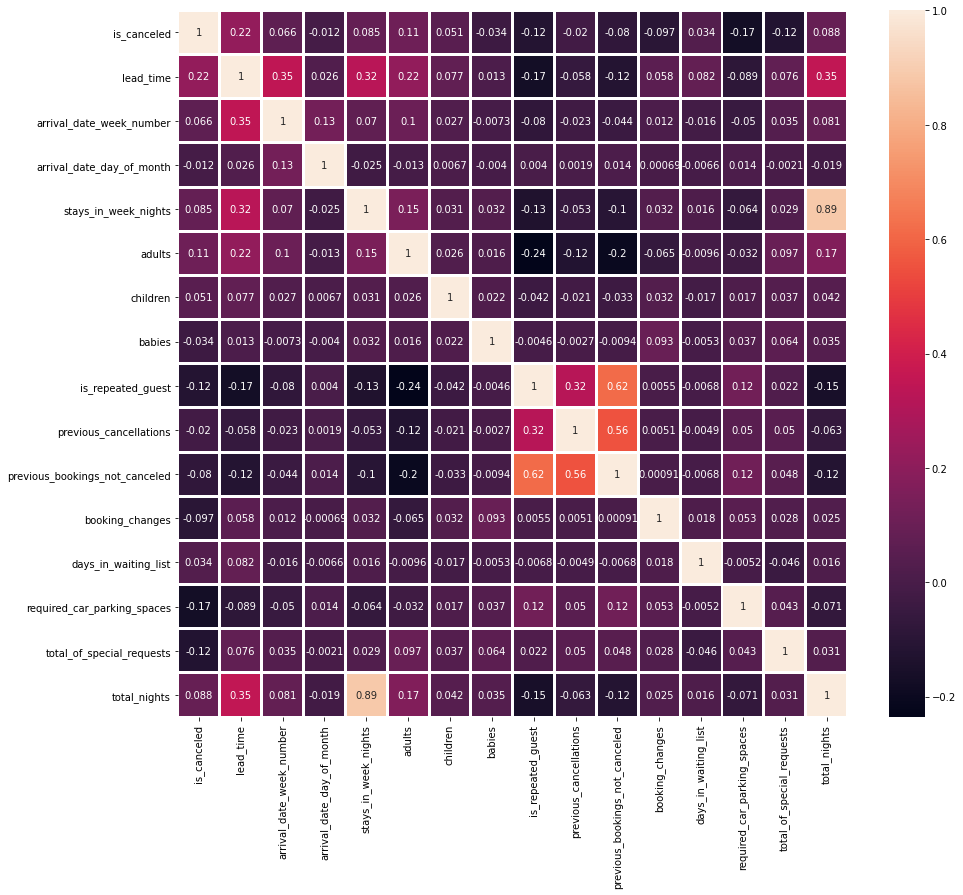

In [70]:
plt.figure(figsize=(15, 13))

sns.heatmap(df_test.drop('income', axis=1).corr(), linewidth=2, annot=True)

plt.show()

### Вывод

Видно что наибольшая зависимость у признака `is_canceled` от признака `lead_time`, т.е. чем больше время от бронирования номера до даты заселения, тем выше вероятность отмены.

Обратные зависимости примерно одного порядка есть с признаками `is_repeated_guest`, `booking_changes`, `required_car_parking_spaces`, `total_of_special_requests`.


Проверим так же как коррелирует вероятность отмены c другими факторами при определённых условиях. Например, при различном количестве младенцев и детей.

In [71]:
df_train.query('children == 3')['arrival_date_week_number']

3377     34
6316     48
6866      1
8673     14
13772    33
19003    21
20586    31
27978     6
Name: arrival_date_week_number, dtype: int64

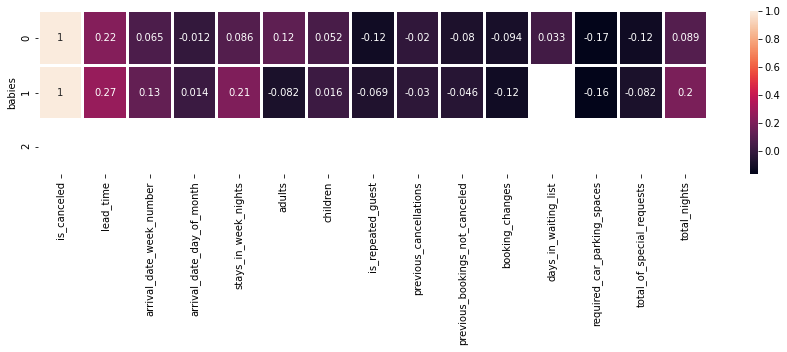

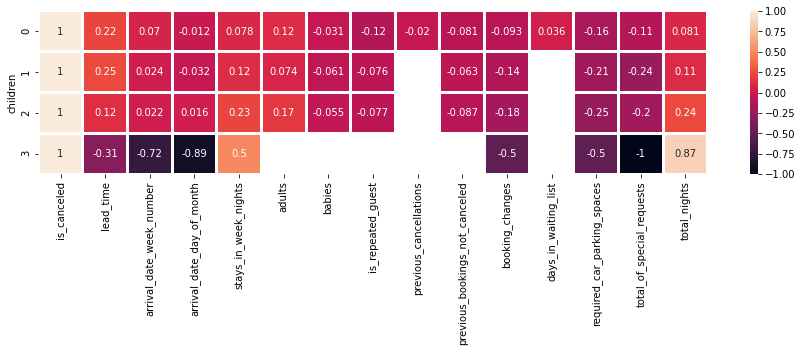

In [72]:
for kids in ['babies', 'children']:
    
    plt.figure(figsize=(15, 3))

    sns.heatmap(df_test.drop('income', axis=1).groupby(kids).corrwith(df_test['is_canceled']), linewidth=2, annot=True)

    plt.show()

Видно что вероятность отказа от брони возрастает в случае с количеством младенцев, падает в зависимости от количества детей. Вероятно, отпуск с младенцами непредсказуем, а с большой семьёй чаще делается в соответствии с планом.

Та же ситуация с неделей заезда. Вероятность отмены отпуска с семьёй с 3мя детьми невелика и наверняка будут дополнительные запросы.

Также с возрастанием количества детей возрастает вероятность отмены при увеличении длительности снятия номера.

В целом эти факторы говорят о том что клиенты которые останавливаются в отеле в первый раз, не вносят в бронь изменений, не бронируют место под машину, не делают специальных запросов и бронируют номер сильно заранее более склонны к отмене и являются "ненадёжными".

## Общий вывод

Мы подготовили и очистили данные. Подобрали метрики и написали функции необходимые для решения задачи.

Проанализировали ряд моделей машинного обучения с учителем.

In [73]:
pd.DataFrame(
    results_table, index=[
        'F1', 'Accuracy', 'TN', 'FP', 'FN', 'TP', 'Precision', 'Recall', 'Income_score', 'Income_score_mod'
    ]
).transpose()

,F1,Accuracy,TN,FP,FN,TP,Precision,Recall,Income_score,Income_score_mod
DummyClassifierRandom,0.386,0.499,8402.0,8411.0,3887.0,3869.0,0.315,0.499,40.725,28.416
DummyClassifierConstant,0.000,0.684,16813.0,0.0,7756.0,0.0,0.000,0.000,32.220,32.220
RandomForestClassifier,0.551,0.710,13080.0,3733.0,3389.0,4367.0,0.539,0.563,41.812,34.697
AdaBoostClassifier,0.177,0.707,16605.0,208.0,6985.0,771.0,0.788,0.099,34.067,33.534
GradientBoostingClassifier,0.218,0.714,16557.0,256.0,6776.0,980.0,0.793,0.126,34.525,33.839
LogisticRegression,0.559,0.715,13134.0,3679.0,3322.0,4434.0,0.547,0.572,42.137,34.815
LinearSVC,0.564,0.642,10089.0,6724.0,2071.0,5685.0,0.458,0.733,44.803,32.105


Все из протестированных моделей обеспечивают прирост прибыли и по совокупности факторов работают лучше случайных или константных моделей. Все модели за год отобьют бюджет проектирования системы прогнозирования.

Выбор конкретной модели для работы зависит от приоритетов стоящих перед бизнесом.

Если нужно **максимизировать прибыль** - подойдёт модель **LinearSVC**.

Если нужно **минимизировать неоправданные залоги**, которые могут отпугнуть клиентов - модель **AdaBoostClassifier**.

**Сбалансированное решение** - модель **RandomForestClassifier**.

Признак `is_repeated_guest` хорошо коррелирует одновременно и с `previous_cancelations` и с `previous_bookings_not_canceled`, вероятно, речь о бизнес клиентах, для которых характерны частые отмены при изменении планов, но которые предпочитают останавливаться в одном и том же месте. Данные клиенты, зная что вероятность отмены всегда есть, станут фактором снижения доходов от введения системы залогов. Таких клиентов стоит перевести в отдельную категорию, которую не будет касаться система залогов.

Таким образом можно резюмировать что машинное обучение может существенно увеличить выручку при грамотном применении и отбить затраты на введение системы оценки рисков, но при этом настоятельно рекомендуется провести А/В тест и выяснить какой процент от клиентов в действительности откажется от брони если система потребует таковую. Это поможет минимизировать риски и выбрать оптимальную по доходности модель.